In [1]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from datetime import datetime
import os
from configparser import ConfigParser
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from langdetect import detect
import langdetect
from textblob import TextBlob
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from prettytable import PrettyTable
from tabulate import tabulate
import numpy as np
from collections import defaultdict
import warnings
# from pandas.core.common import SettingWithCopyWarning
from nltk.stem import WordNetLemmatizer
import scipy.stats
# Ignore the warning
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# A sample code for data preparation has been given below. Feel free to edit when needed

# Load the videos and comments dataframes from their respective CSV files
videos_df = pd.read_csv('videos.csv')
comments_df = pd.read_csv('comments.csv')

# Convert the published_at column to a datetime object for videos_df
videos_df['published_at'] = pd.to_datetime(videos_df['published_at'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
videos_df['published_at_week'] = videos_df['published_at'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
videos_df['published_at_month'] = videos_df['published_at'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
videos_df['published_at_year'] = videos_df['published_at'].dt.strftime('%Y')

# Convert the published_at column to a datetime object for comments_df
comments_df['comment_date'] = pd.to_datetime(comments_df['comment_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
comments_df['comment_date_week'] = comments_df['comment_date'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
comments_df['comment_date_month'] = comments_df['comment_date'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
comments_df['comment_date_year'] = comments_df['comment_date'].dt.strftime('%Y')

# Convert the duration column to seconds for videos_df
videos_df['duration'] = videos_df['duration'].apply(lambda x: re.findall(r'PT(\d+)M(\d+)S', x))
videos_df['duration'] = videos_df['duration'].apply(lambda x: int(x[0][0]) * 60 + int(x[0][1]) if len(x) > 0 else 0)

# Prepared DataFrame objects; can be used for data analysis
videos = videos_df
comments = comments_df
videos_comments = pd.merge(videos,comments, on='video_id', how = 'inner') # merged videos and comments

In [3]:
# # This function takes a text input and returns its sentiment (polarity) score
# # If the text is null, it returns 0
# def get_sentiment_score(text):
#     if pd.isnull(text):
#         return 0
#     else:
#         return TextBlob(text).sentiment.polarity
    
# # This function takes a text input and returns its sentiment category
# # If the text is null, it returns 'neutral'
# # If the polarity score is greater than 0, it returns 'positive'
# # If the polarity score is less than 0, it returns 'negative'
# # Otherwise, it returns 'neutral'
# def get_sentiment(text):
#     if pd.isnull(text):
#         return 'neutral'
#     else:
#         blob = TextBlob(text)
#         if blob.sentiment.polarity > 0:
#             return 'positive'
#         elif blob.sentiment.polarity < 0:
#             return 'negative'
#         else:
#             return 'neutral'

## Code for NLP models 

Because I feel like `TextBlob` library gives not very accurate sentiment scores, so I use a pretrained model from `HuggingFace` that is trained from 58 million tweets. The threshold is 0.5, below or above that is negative and positive. I have attached the code to categorize the scores of each `comments` and `video titles` below. For convenience sake, I have exported what the model predicts into a `csv` file.

Link for the model: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

In [4]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
# model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
# # Set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move the model to the selected device
# model.to(device)
# import torch.nn.functional as F


# def sentiment_score(text):
#     if isinstance(text, str):
#         # Encode the text using tokenizer
#         encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
#         # Move the tensor to the correct device
#         encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
#         # Forward pass through the model to get the logits
#         with torch.no_grad():
#             logits = model(**encoded_input).logits
#         # Apply softmax to get probabilities
#         probabilities = F.softmax(logits, dim=1).squeeze()
#         # Return the probability corresponding to positive sentiment
#         return probabilities[1].item()
#     else:
#         return None

# def translate_column_to_scores(df, column_name):
#     scores = []
#     for text in df[column_name]:
#         # Apply the sentiment scoring function to each text entry
#         score = sentiment_score(text)
#         scores.append(score)
#     # Create a new column in the DataFrame with the sentiment scores
#     df[column_name + '_sentiment_score'] = scores
#     return df

# df2 = translate_column_to_scores(df2, 'video_title')
# df2 = translate_column_to_scores(df2, 'comment_text')

## Task 2
##### E.2. Use regression analysis with visualization to test the following hypothesises:

* H1: There is a meaningful relationship between the sentiment of a video title and the sentiments of its corresponding comments.  
* H2: There is a meaningful relationship between the video likes and the sentiments of its corresponding comments.
* H3: There is a meaningful relationship between the duration of a video and the sentiments of its corresponding comments.

## Explain before going into the analysis
I will be dividing this analyzing into 2 parts. 
- The first one is exploring only the 3 independent variables (`video title sentiment`, `video likes`, `duration`) with the response variable (`comments sentiment`). I will be exploring them by examining the correlation and use some regression techniques to analyze them.
- In the second part, I add more predictors to the model to enhance my answers from part 1.

# Part 1
Before going into any analysis, I want to compare the different between `correlation` and `regression`. Correlation hints a relationship between two variables via the strength and direction. We can see if there's a statistical association by examining the correlation coefficient. Regression looks at independent variable(s) and dependent variable. It predicts whether a change in the predictors will affect the response variable

,video_title,video_title_sentiment_score,comment_sentiment_score
337,novel coronavirus explained l abc news,0.822,0.612650
451,who declares coronavirus outbreak a pandemic,0.344,0.396364


(464, 3)

,video_title,like_count,comment_sentiment_score
321,missouri becomes first state to sue china over...,8778.0,0.398316
375,state department warns us citizens not to trav...,1460.0,0.349350


(464, 3)

,video_title,duration,comment_sentiment_score
141,coronavirus what has covid done for climate cr...,165.0,0.417857
217,essential farmworkers risk infection and depor...,481.0,0.430160


(464, 3)

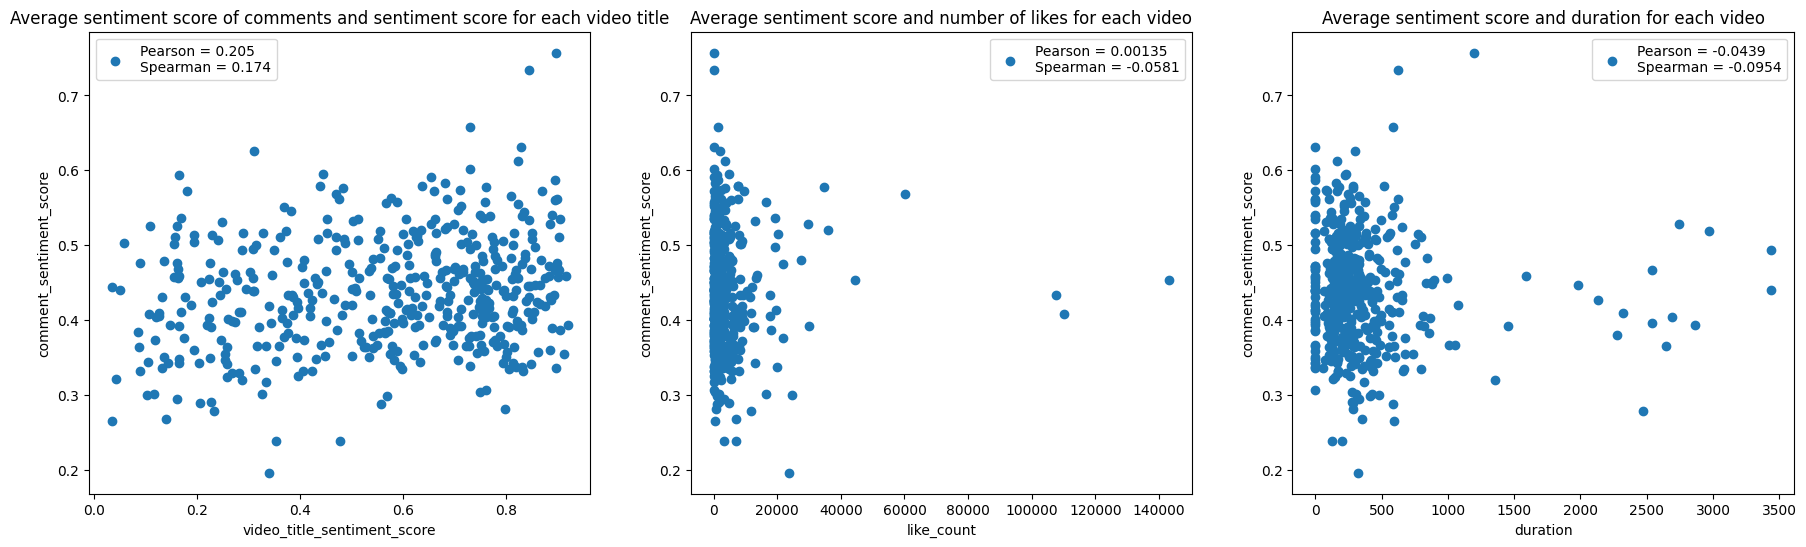

In [5]:
# load the data
df2 = pd.read_csv('sentiment_scores.csv')
df3 = df2.copy()


# create subplots for each plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
def plot_corr(x, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    r = scipy.stats.pearsonr(x, y)[0]
    ρ = scipy.stats.spearmanr(x, y)[0]
    ax.scatter(x, y, label=f"Pearson = {r:.3}\nSpearman = {ρ:.3}")
    ax.legend()
    if title:
        ax.set_title(title)
        ax.set_xlabel(x.name)
        ax.set_ylabel(y.name)

# Round the data
df2['video_title_sentiment_score'] = df2['video_title_sentiment_score'].round(3)
df2.rename({'comment_text_sentiment_score':'comment_sentiment_score'}, axis=1, inplace=True)
df2['comment_sentiment_score'] = df2['comment_sentiment_score'].round(3)

# group the comments by video and calculate the average sentiment score of comments and sentiment score for each video title
grouped_data1 = df2.groupby('video_title')[['video_title_sentiment_score', 'comment_sentiment_score']].mean().reset_index()
display(grouped_data1.sample(2), grouped_data1.shape)

# plot the first subplot
plot_corr(grouped_data1['video_title_sentiment_score'], grouped_data1['comment_sentiment_score'], axes[0], 'Average sentiment score of comments and sentiment score for each video title')

# group the comments by video and calculate the average sentiment score and number of likes for each video
grouped_data2 = df2.groupby(['video_title'])[['like_count', 'comment_sentiment_score']].mean().reset_index()
display(grouped_data2.sample(2), grouped_data2.shape)

# plot the second subplot
plot_corr(grouped_data2['like_count'], grouped_data2['comment_sentiment_score'], axes[1], 'Average sentiment score and number of likes for each video')

# group the comments by video and calculate the average sentiment score and duration for each video
grouped_data3 = df2.groupby(['video_title'])[['duration', 'comment_sentiment_score']].mean().reset_index()
display(grouped_data3.sample(2), grouped_data3.shape)

# plot the third subplot
plot_corr(grouped_data3['duration'], grouped_data3['comment_sentiment_score'], axes[2], 'Average sentiment score and duration for each video')

Notes before explaining the observations. 

I use scatterplots to look at the relationship between two variables. There are 2 types of correlations I used, which are Pearson and Spearman. Pearson assumes we have a normally distribution and have continous variables. Spearman measures a monotonic relationship (meaning if one increases, the other increases as well) and does not assume we have a normal distribution.

**Observation**

From the plots, we can see that `video_title_sentiment_score` and `duration` shows some correlation. The `like_count` doesn't seem to be correlated. From the correlation analysis, we can conclude that `video_title_sentiment_score` have a positive statistical association with the `comment_sentiment_score` and the `duration` have negative one
.

## Performing regression analysis
**I will first merge the three grouped data dataframe via `video_title`**

In [6]:
display(grouped_data1.shape, grouped_data2.shape, grouped_data3.shape)
# first merge
merge_df = pd.merge(grouped_data1, grouped_data2, on='video_title')

merge_df.drop(['comment_sentiment_score_y'], axis=1, inplace=True)
merge_df.rename({'comment_sentiment_score_x':'comment_sentiment_score'}, axis=1, inplace=True)

# # second merge
merge_df = pd.merge(merge_df, grouped_data3, on='video_title')
merge_df.drop(['comment_sentiment_score_y'], axis=1, inplace=True)
merge_df.rename({'comment_sentiment_score_x':'comment_sentiment_score'}, axis=1, inplace=True)
display(merge_df.head(3), merge_df.shape)

(464, 3)

(464, 3)

(464, 3)

,video_title,video_title_sentiment_score,comment_sentiment_score,like_count,duration
0,states report rise in new coronavirus cases,0.752,0.44220,680.0,119.0
1,states see an increase in coronavirus cases,0.669,0.41930,8897.0,344.0
2,states set daily record for coronavirus cases...,0.854,0.41045,2435.0,0.0


(464, 5)

In [7]:
merge_df.isna().sum()

video_title                    0
video_title_sentiment_score    0
comment_sentiment_score        0
like_count                     0
duration                       0
dtype: int64

### Things to look for before doing regression analysis
**Summary output**

1. `R-squared`: Measures the amount of variability in a dependent variable can be explained in the independent variable in the range of 0 to 1(1 is the best). In other words, it tells us if the y can be predicted by the x.
2. `Prob (F-statistics)`: p-value of F-statistics. It test the significance for the entire regression. At α = 0.05, this regression is statistically significant when p-value < 0.05. If p-value < 0.05 means we can reject the null hypothesis and conclude that the overall regression model is statistically significant. In other words, there is strong evidence suggesting that independent variables have significant effect on the dependent variable.
3. `P>|t|`: p-value of the coefficient's t-test. Similar to the one above, if p-value < 0.05, we reject the null hypothesis which is coefficient is equal to 0 or in other words, the predictor variable has no effect on the dependent variable.
4. `Prob(Omnibus) and Prob(JB)`: checks if the residuals are normally distributed, the test the p-value with the null hypothesis is the residuals is normally distributed.

**Check assumption**

1. `Multicollinearity`
   - Two or more independent variables are highly correlated => makes it hard to distinguish the individual effects of the predictors on the dependent variable
2. `Non-Normality of Residuals`
   - In regression analysis, we assume all residuals are normally distributed. Any deviations from this can effect the reliability of our hypothesis tests.
   - `Shapiro-Wilk Test` will best show if our distribution is normal or not. If p-value are extremely low, which reject the null hypothesis that the residuals are normally distributed. In other words, there is a significant deviation from normality.

**Scale data and regression model**

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler

# Scale the data because we need them on the same scale
scaler = StandardScaler()
merge_df_scaled = merge_df.drop(['video_title'], axis=1)
merge_df_scaled = scaler.fit_transform(merge_df_scaled) 
merge_df_scaled = pd.DataFrame(merge_df_scaled, columns=merge_df.drop(['video_title'], axis=1).columns)
# Fit the model
model = ols("comment_sentiment_score ~ video_title_sentiment_score + like_count + duration", data=merge_df_scaled).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     comment_sentiment_score   R-squared:                       0.045
Model:                                 OLS   Adj. R-squared:                  0.039
Method:                      Least Squares   F-statistic:                     7.254
Date:                     Fri, 26 Apr 2024   Prob (F-statistic):           9.18e-05
Time:                             10:55:05   Log-Likelihood:                -647.66
No. Observations:                      464   AIC:                             1303.
Df Residuals:                          460   BIC:                             1320.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

**Explain**
- `R-squared`: The result shows about 4.5% of the total variation in the `comment_text_sentiment_score` is explained by regression model.
- `Prob (F-statistic)`: a very low value, smaller than 0.05. This indicates that there is strong evidence that independent variables have significant effect on the dependent variable.
- `P>|t|`:
  - `const`: 1.0, a very bad baseline effect when all predictors are zero
  - only `video_title_sentiment_score` p-value rejects the null hypothesis which is the predictor variable has no effect on the dependent variable. The other independent variables accept the null hypothesis.

**Shapiro-Wilk Test to check if the residual is normally distributed or not**

In [9]:
from scipy.stats import shapiro

residuals = model.resid
stat, p = shapiro(residuals)
print('Shapiro-Wilk Test Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk Test Statistics=0.990, p=0.003


From the `Shapiro-Wilk Test`, we can see that the p-value < 0.05, which reject the null hypothesis that the residuals are normally distributed. In other words, there is a significant deviation from normality.

**Conclusion from part 1**

Only `video_title_sentiment_score` has a meaningful relationship with `comment_sentiment_score`. We need to further analyze the data to imporve the model and find out if other predictors have a meaninful relationship with the response variable.

## Part 2

In [10]:
df3.columns

Index(['video_id', 'channel_id', 'video_title', 'channel_title',
       'category_name', 'live_upcoming_none', 'view_count', 'like_count',
       'dislike_count', 'comment_count', 'published_at', 'tags', 'duration',
       'definition', 'caption', 'thumbnail', 'url', 'published_at_week',
       'published_at_month', 'published_at_year', 'comment_id', 'comment_text',
       'comment_author', 'comment_date', 'comment_like_count',
       'parent_comment_id', 'comment_date_week', 'comment_date_month',
       'comment_date_year', 'video_title_sentiment_score',
       'comment_text_sentiment_score'],
      dtype='object')

In [11]:
df3.drop(['channel_id', 'video_title', 'live_upcoming_none', 'tags', 'caption',
         'thumbnail', 'url', 'comment_id', 'comment_text', 'comment_date', 'parent_comment_id', 'comment_date_week', 'definition',
          'comment_date_month', 'comment_date_year', 'comment_author'], axis=1, inplace=True)
display(df3.head(1), df3.dtypes)

,video_id,channel_title,category_name,view_count,like_count,dislike_count,comment_count,published_at,duration,published_at_week,published_at_month,published_at_year,comment_like_count,video_title_sentiment_score,comment_text_sentiment_score
0,d1eEWihvwpQ,Fox News,News & Politics,456892,3624,0,1940,2020-03-11 16:50:56,0,2020-03-10,2020-03,2020,1.0,0.343503,0.169326


video_id                         object
channel_title                    object
category_name                    object
view_count                        int64
like_count                        int64
dislike_count                     int64
comment_count                     int64
published_at                     object
duration                          int64
published_at_week                object
published_at_month               object
published_at_year                 int64
comment_like_count              float64
video_title_sentiment_score     float64
comment_text_sentiment_score    float64
dtype: object

**Deal with datetime**

In [12]:
df3.drop(['published_at_month', 'published_at_year', 'published_at_week'], axis=1, inplace=True) # dropping some unnecessary date cols
df3.published_at = pd.to_datetime(df3.published_at, errors='coerce') # convert the datetime dtype

# Extract features
df3['year'] = df3.published_at.dt.year
df3['month'] = df3.published_at.dt.month
df3['day'] = df3.published_at.dt.day

# Drop the datetime
df3.drop(['published_at'], axis=1, inplace=True)
df3.dtypes

video_id                         object
channel_title                    object
category_name                    object
view_count                        int64
like_count                        int64
dislike_count                     int64
comment_count                     int64
duration                          int64
comment_like_count              float64
video_title_sentiment_score     float64
comment_text_sentiment_score    float64
year                              int32
month                             int32
day                               int32
dtype: object

**Label the channel title and category name with number**

In [13]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the label encoder to the unique channel titles and transform them to numeric labels
encoded_channels = label_encoder.fit_transform(df3['channel_title'])
encoded_category = label_encoder.fit_transform(df3['category_name'])

# Assign the encoded channels to a new column in the DataFrame
df3['channel_label'] = encoded_channels
df3['category_label'] = encoded_category

df3.drop(['channel_title', 'category_name'], axis=1, inplace=True)
df3.head(1)

,video_id,view_count,like_count,dislike_count,comment_count,duration,comment_like_count,video_title_sentiment_score,comment_text_sentiment_score,year,month,day,channel_label,category_label
0,d1eEWihvwpQ,456892,3624,0,1940,0,1.0,0.343503,0.169326,2020,3,11,4,1


In [14]:
# Check for missing values
df4 = df3.copy()
display(df4.shape, df4.isna().sum())
df4.dropna(axis=0, inplace=True)
display(df4.shape, df4.isna().sum())

(11652, 14)

video_id                          0
view_count                        0
like_count                        0
dislike_count                     0
comment_count                     0
duration                          0
comment_like_count                2
video_title_sentiment_score       0
comment_text_sentiment_score    195
year                              0
month                             0
day                               0
channel_label                     0
category_label                    0
dtype: int64

(11455, 14)

video_id                        0
view_count                      0
like_count                      0
dislike_count                   0
comment_count                   0
duration                        0
comment_like_count              0
video_title_sentiment_score     0
comment_text_sentiment_score    0
year                            0
month                           0
day                             0
channel_label                   0
category_label                  0
dtype: int64

In [15]:
df4.columns

Index(['video_id', 'view_count', 'like_count', 'dislike_count',
       'comment_count', 'duration', 'comment_like_count',
       'video_title_sentiment_score', 'comment_text_sentiment_score', 'year',
       'month', 'day', 'channel_label', 'category_label'],
      dtype='object')

In [16]:
col = ['video_id', 'year', 'month', 'day', 'channel_label', 'category_label']

grouped_df1 = df4.groupby(col)[['video_title_sentiment_score', 'comment_text_sentiment_score']].mean().reset_index()
grouped_df2 = df4.groupby(col)[['like_count', 'comment_text_sentiment_score']].mean().reset_index()
grouped_df3 = df4.groupby(col)[['duration', 'comment_text_sentiment_score']].mean().reset_index()
grouped_df4 = df4.groupby(col)[['view_count', 'comment_text_sentiment_score']].mean().reset_index()
grouped_df5 = df4.groupby(col)[['comment_count', 'comment_text_sentiment_score']].mean().reset_index()

In [17]:
# first merge
df5 = pd.merge(grouped_df1, grouped_df2, on=col)

df5.drop(['comment_text_sentiment_score_y'], axis=1, inplace=True)
df5.rename({'comment_text_sentiment_score_x':'comment_text_sentiment_score'}, axis=1, inplace=True)

# second merge
df5 = pd.merge(df5, grouped_df3, on=col)
df5.drop(['comment_text_sentiment_score_y'], axis=1, inplace=True)
df5.rename({'comment_text_sentiment_score_x':'comment_text_sentiment_score'}, axis=1, inplace=True)

# third merge
df5 = pd.merge(df5, grouped_df4, on=col)
df5.drop(['comment_text_sentiment_score_y'], axis=1, inplace=True)
df5.rename({'comment_text_sentiment_score_x':'comment_text_sentiment_score'}, axis=1, inplace=True)

# fourth merge
df5 = pd.merge(df5, grouped_df5, on=col)
df5.drop(['comment_text_sentiment_score_y'], axis=1, inplace=True)
df5.rename({'comment_text_sentiment_score_x':'comment_text_sentiment_score'}, axis=1, inplace=True)

df5.drop('video_id', axis=1, inplace=True)
display(df5.head(3), df5.shape)

,year,month,day,channel_label,category_label,video_title_sentiment_score,comment_text_sentiment_score,like_count,duration,view_count,comment_count
0,2020,7,10,9,1,0.368837,0.550584,2686.0,597.0,221041.0,1407.0
1,2020,7,21,6,1,0.249831,0.464576,1114.0,526.0,98500.0,272.0
2,2020,3,14,11,1,0.542418,0.379195,2521.0,224.0,341915.0,408.0


(507, 11)

**Check for correlations of all variables before doing the regression analysis**

The reason for this is because we do not want two or more independent variables correlated with each other. What I mean by this is that we want to avoid `Multicollinearity`. This is especially important when we are analysing many features.

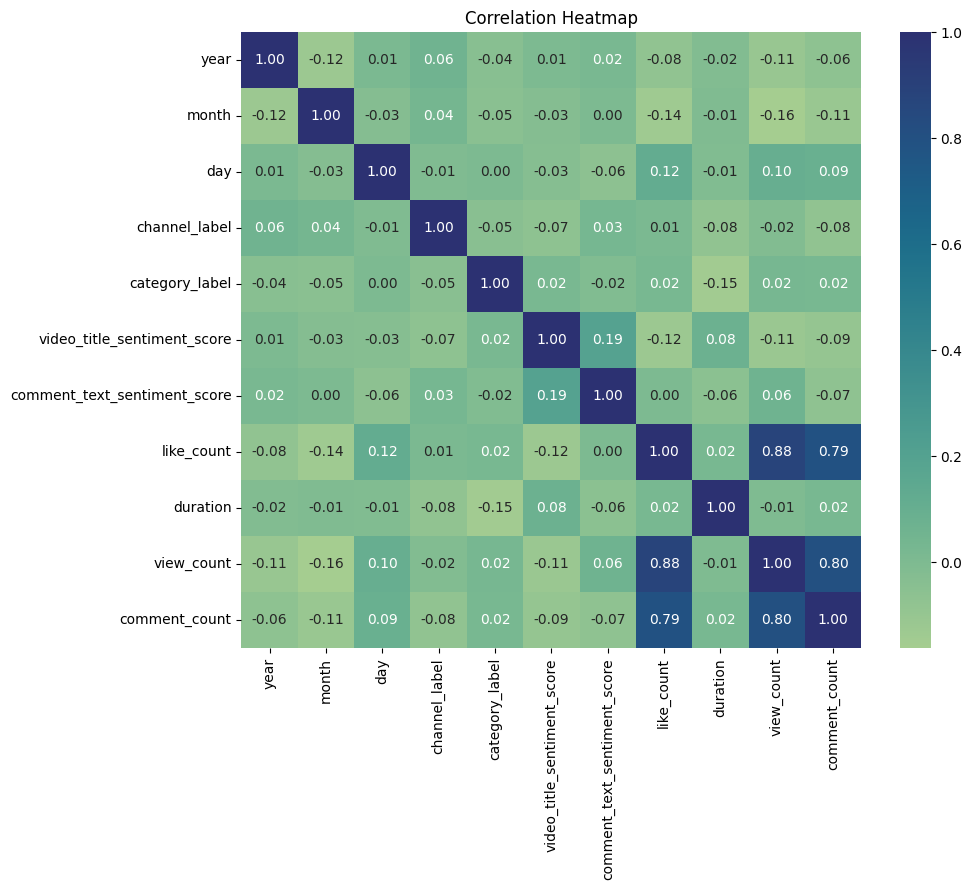

In [18]:
# Compute pairwise correlation matrix
corr = df5.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='crest', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

`comment_count`, `view_count`, `like_count` are 3 independent variables that are correlated. I will drop `comment_count`, `like_count` as we only need  1 and `view_count` correlation is a bit better than the other two.

In [19]:
df5.drop(['comment_count', 'like_count'], axis=1, inplace=True)

scaler = StandardScaler()
x = df5.drop(['comment_text_sentiment_score'], axis=1)
x = scaler.fit_transform(x)  

y = df5['comment_text_sentiment_score']
x = sm.add_constant(x) 

model = sm.OLS(y, x).fit()
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     comment_text_sentiment_score   R-squared:                       0.058
Model:                                      OLS   Adj. R-squared:                  0.043
Method:                           Least Squares   F-statistic:                     3.827
Date:                          Fri, 26 Apr 2024   Prob (F-statistic):           0.000221
Time:                                  10:55:06   Log-Likelihood:                 609.83
No. Observations:                           507   AIC:                            -1202.
Df Residuals:                               498   BIC:                            -1164.
Df Model:                                     8                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

If we add more predictors, we see that `R-squared` is 0.058, but there are many more things we would need to diagnose. One thing to keep in mind is that the `R-squared` will increase if I add more predictor, but we need to beaware of overfitting. We do not want to just throw random predictors in the model and expect it to perform well. 

#### Regression diagnostics
https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html

**Normality of the residuals**

In [20]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(model.resid)
lzip(name, test)

[('Jarque-Bera', 25.512975558171973),
 ('Chi^2 two-tail prob.', 2.883551744309365e-06),
 ('Skew', 0.42176670720321074),
 ('Kurtosis', 3.704390657307147)]

In [21]:
name = ["Chi^2", "Two-tail probability"]
test = sms.omni_normtest(model.resid)
lzip(name, test)

[('Chi^2', 21.355121258361898),
 ('Two-tail probability', 2.3056550803494324e-05)]

`Chi^2 two-tail prob `: 2.883551744309365e-06 and `Two-tail probability`: 2.3056550803494324e-05 confirm our the residuals do not follow a normal distribution as the `p-value` as smaller than 0.05

**Influence tests**

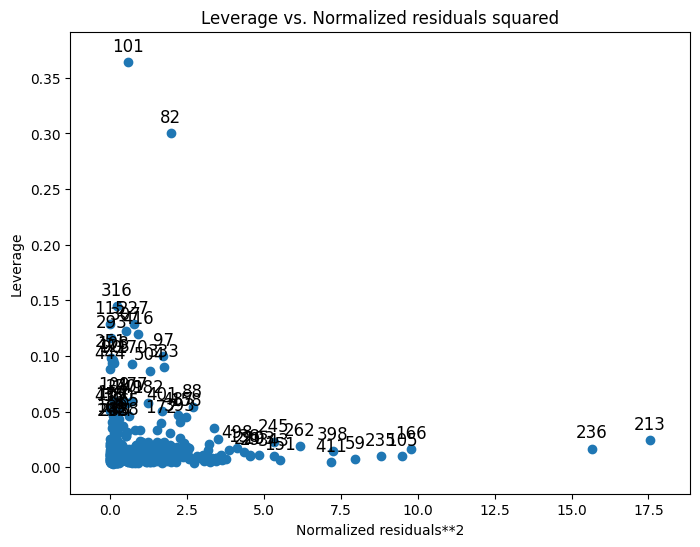

In [22]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(model, ax=ax)

- `Leverage`: y-axis. Points with high leverage have a high influence on the regression line
- `Normalized Residuals Squared`: x-axis. Large values may indicate outliers in the response variable
- We can see some high leverage and high residual points like 236 or 213; high leverage but low resisuals like 82 and 101. There might be some indication of outlier, we need to use **Cook’s Distance** to confirm this.

**Cook’s Distance**
- Source: https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a
- Cook’s Distance is a summary of how much a regression model changes when <i>i</i>th observation is removed. It also take into account of the leverage and residual of each observation

Say we want to remove outliers so we could fit a better model. I will filter out any values greater than 3 times the mean

In [23]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Calculate Cook's distance
cooks_d = OLSInfluence(model).cooks_distance[0]

# Calculate the threshold for identifying influential points
threshold = 3 * np.mean(cooks_d)

# Find influential points
influential_indices = np.where(cooks_d > threshold)[0]
influential = cooks_d[influential_indices]

print(influential)

18     0.010215
59     0.006533
82     0.130874
88     0.017633
97     0.023069
101    0.056793
105    0.010502
138    0.006573
158    0.013341
166    0.017649
170    0.008726
172    0.007788
182    0.008648
213    0.048443
227    0.014180
235    0.009677
236    0.029544
245    0.013610
262    0.013137
284    0.006779
307    0.008633
313    0.007517
325    0.006911
333    0.020483
393    0.011017
398    0.012131
401    0.010302
416    0.014899
475    0.006605
487    0.012454
498    0.007967
502    0.013780
504    0.014580
dtype: float64


Let's exclude these points from our model

In [24]:
scaler = StandardScaler()

# Remove the outler
df5_cleaned = df5.drop(influential_indices)
# Fit the model again with the cleaned dataset
x_cleaned = df5_cleaned.drop(['comment_text_sentiment_score'], axis=1)
x_cleaned = scaler.fit_transform(x_cleaned)
x_cleaned = sm.add_constant(x_cleaned)
y_cleaned = df5_cleaned['comment_text_sentiment_score']

model_cleaned = sm.OLS(y_cleaned, x_cleaned).fit()
print(model_cleaned.summary())

                                 OLS Regression Results                                 
Dep. Variable:     comment_text_sentiment_score   R-squared:                       0.067
Model:                                      OLS   Adj. R-squared:                  0.051
Method:                           Least Squares   F-statistic:                     4.157
Date:                          Fri, 26 Apr 2024   Prob (F-statistic):           8.15e-05
Time:                                  10:55:06   Log-Likelihood:                 632.20
No. Observations:                           474   AIC:                            -1246.
Df Residuals:                               465   BIC:                            -1209.
Df Model:                                     8                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

So there is an increase in `R-squared` after outlier is removed using **Cook’s Distance**

**Multicollinearity**

Multicollinearity is when independent variables are highly correlated with each other. The residuals may follow a normal distribution

In [25]:
np.linalg.cond(model_cleaned.model.exog)

1.3434856005044828

This test shows a low condition number. But I want to use `VIF`. Anything around 5 is acceptable, 10 we need to remove.

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the response variable from the DataFrame
X = df5_cleaned.drop(['comment_text_sentiment_score'], axis=1)

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                      Variable         VIF
0                         year  149.180658
1                        month    4.372262
2                          day    4.760154
3                channel_label    3.604134
4               category_label  123.702400
5  video_title_sentiment_score    7.478787
6                     duration    1.532264
7                   view_count    1.333762


Here is the VIF for each variable
- `year` and `category_label` have high VIF values ->  strong multicollinearity

To deal with high multicollinearity, I will use drop `year` and `category_label`.

In [27]:
scaler = StandardScaler()

df5_cleaned_reduced = df5_cleaned.drop(['year', 'category_label'], axis=1)

# Separate the predictor variables (X) and the response variable (y)
X_reduced = df5_cleaned_reduced.drop(['comment_text_sentiment_score'], axis=1)
X_reduced = scaler.fit_transform(X_reduced)
X_reduced = sm.add_constant(X_reduced)
y_reduced = df5_cleaned_reduced['comment_text_sentiment_score']

# Fit the new model
model_reduced = sm.OLS(y_reduced, X_reduced).fit()
print(model_reduced.summary())

                                 OLS Regression Results                                 
Dep. Variable:     comment_text_sentiment_score   R-squared:                       0.062
Model:                                      OLS   Adj. R-squared:                  0.050
Method:                           Least Squares   F-statistic:                     5.111
Date:                          Fri, 26 Apr 2024   Prob (F-statistic):           4.24e-05
Time:                                  10:55:06   Log-Likelihood:                 630.90
No. Observations:                           474   AIC:                            -1248.
Df Residuals:                               467   BIC:                            -1219.
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [28]:
np.linalg.cond(model_reduced.model.exog)

1.2475116620048101

After dropping those two columns, our model multicollinearity decreases.

**Heteroskedasticity tests**

`Heteroskedasticity` means the variance of the residuals is not constant across all levels of independent variables. It just means that there is some sort of pattern in the residual plot.

In [29]:
# Breush-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model_reduced.resid, model_reduced.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 10.654156812470834),
 ('p-value', 0.09967152414859512),
 ('f-value', 1.7896967260263619),
 ('f p-value', 0.09940494659250626)]

In [30]:
# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(model_reduced.resid, model_reduced.model.exog)
lzip(name, test)

[('F statistic', 1.096752367473839), ('p-value', 0.2421449255056596)]

The Breusch-Pagan test assesses the null hypothesis that the variance of the residuals is constant (`homoskedasticity`, the opposite of `heteroskedasticity`). Since p-value > 0.05, which suggest do accept the null hypothesis of our model is `homoskedasticity` (opposite of `Heteroskedasticity`). The same applies for the `Goldfeld-Quandt Test`.

For double checking to see if our model is actually `homoskedasticity`, we need to see plot `Residuals vs. Fitted Values`.

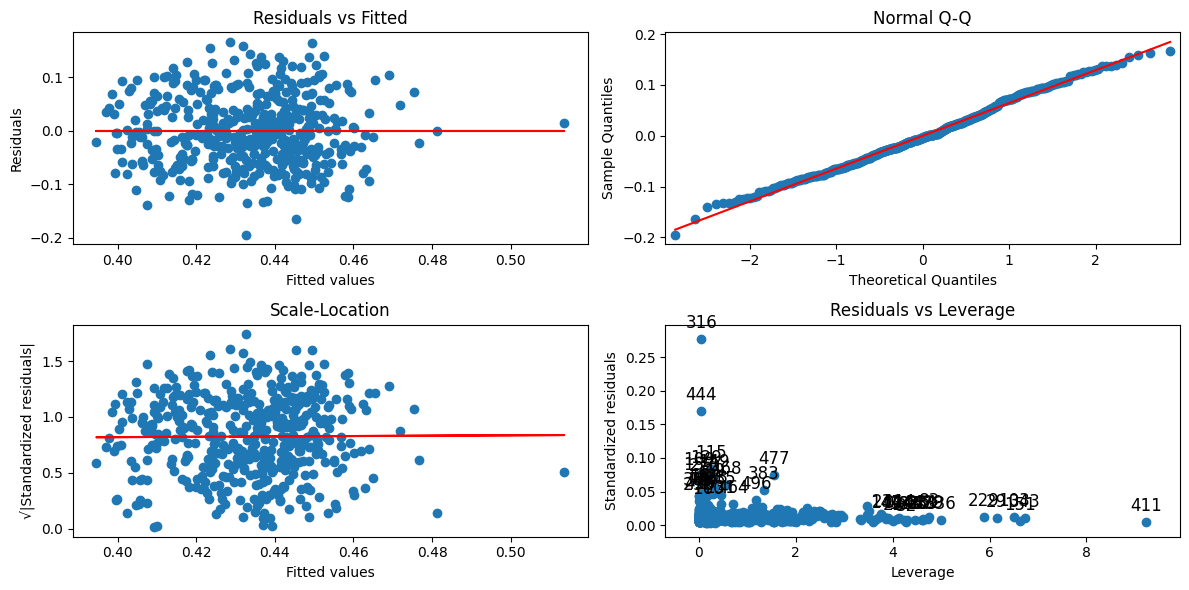

In [31]:
residuals = model_reduced.resid

# Residuals vs Fitted Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.scatter(model_reduced.fittedvalues, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
# Calculate the linear regression line
fit = np.polyfit(model_reduced.fittedvalues, residuals, deg=1)
plt.plot(model_reduced.fittedvalues, fit[0] * model_reduced.fittedvalues + fit[1], color='red')

# Normal QQ Plot
plt.subplot(2, 2, 2)
sm.qqplot(residuals, line='r', ax=plt.gca())
plt.title('Normal Q-Q')

# Scale-Location Plot (Square root of standardized residuals vs. fitted values)
plt.subplot(2, 2, 3)
sqrt_standardized_resid = np.sqrt(np.abs(OLSInfluence(model_reduced).resid_studentized))
plt.scatter(model_reduced.fittedvalues, sqrt_standardized_resid)
plt.xlabel('Fitted values')
plt.ylabel('√|Standardized residuals|')
plt.title('Scale-Location')
# Calculate the linear regression line
fit = np.polyfit(model_reduced.fittedvalues, sqrt_standardized_resid, deg=1)
plt.plot(model_reduced.fittedvalues, fit[0] * model_reduced.fittedvalues + fit[1], color='red')


# Residuals vs Leverage Plot
plt.subplot(2, 2, 4)
sm.graphics.plot_leverage_resid2(model_reduced, ax=plt.gca())
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

In [32]:
from scipy.stats import shapiro

residuals = model_reduced.resid
stat, p = shapiro(residuals)
print('Shapiro-Wilk Test Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk Test Statistics=0.994, p=0.050


- `Residuals vs. Fitted Values` plot (top left): we can see that the residuals are centered around 0, which is good as there is no bias; there is no clear pattern, all random, also good; the spread is consistent which is good -> pretty normally distributed.
- `Normal Q-Q Plot` (Top Right): the points are following the 45 degree line, indicating a normal distribution.
- The other 2 plots show similar results

**Now I will plot any predictors with p-value < 0.05**

In [33]:
column = df5_cleaned_reduced.drop('comment_text_sentiment_score', axis=1)
print(column.columns)
print(model_reduced.summary())

Index(['month', 'day', 'channel_label', 'video_title_sentiment_score',
       'duration', 'view_count'],
      dtype='object')
                                 OLS Regression Results                                 
Dep. Variable:     comment_text_sentiment_score   R-squared:                       0.062
Model:                                      OLS   Adj. R-squared:                  0.050
Method:                           Least Squares   F-statistic:                     5.111
Date:                          Fri, 26 Apr 2024   Prob (F-statistic):           4.24e-05
Time:                                  10:55:06   Log-Likelihood:                 630.90
No. Observations:                           474   AIC:                            -1248.
Df Residuals:                               467   BIC:                            -1219.
Df Model:                                     6                                         
Covariance Type:                      nonrobust                         

**Use plots to examine things further**
- `residual`: checks for the independent variable vs the residuals. We want to see a random scatter of points, not cluster in one side or create some V shape.
- `partial`: compare each individual independent variable with the dependent variable without the affect of other variables.

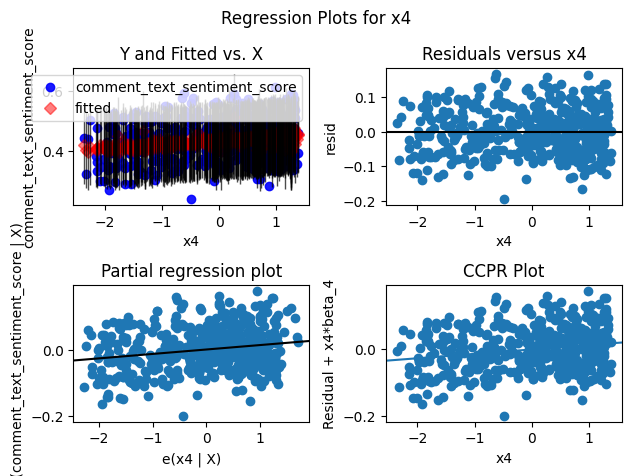

In [34]:
fig = sm.graphics.plot_regress_exog(model_reduced, "x4")
fig.tight_layout(pad=1.0)

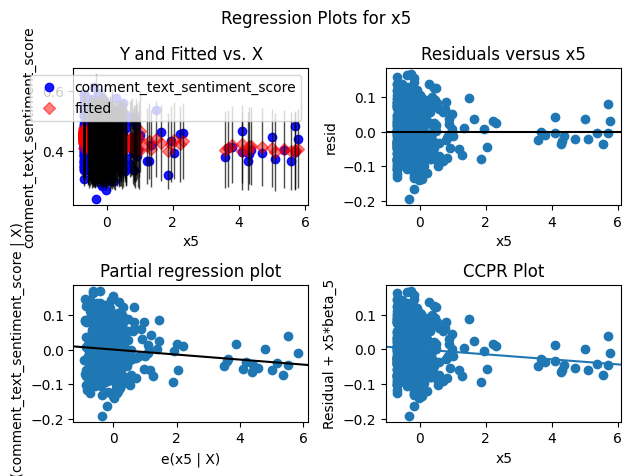

In [35]:
fig = sm.graphics.plot_regress_exog(model_reduced, "x5")
fig.tight_layout(pad=1.0)

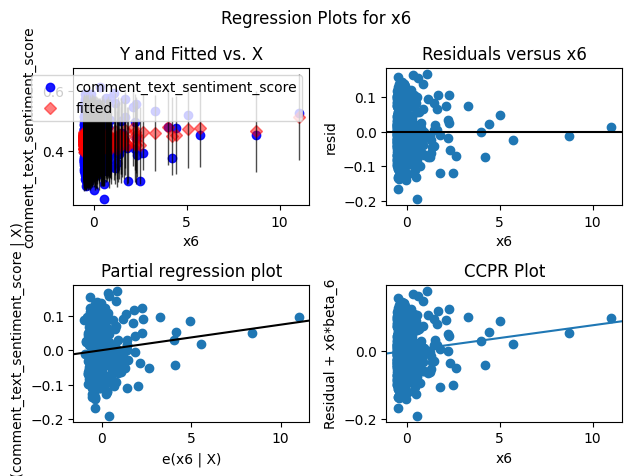

In [36]:
fig = sm.graphics.plot_regress_exog(model_reduced, "x6")
fig.tight_layout(pad=1.0)

- **x4 or video_title_sentiment_score**: we can see that the residual plot shows more dots are clustered on the right than the left, so there seems to be some sort of pattern albeit not much. The p-value associated with t is very small, which indicates this predictor has an affect on the response variable. This is a positive relationship.
- **x5 (duration) and x6 (view_count)**: the residual plots seem to be random as almost all of the dots are clustered on the left. Again, the p-value associated with t is very small, which indicates these predictors have an affect on the response vairable. x6 shows a negative relationship and x7 shows a positive relationship.

## Conclusion
In conclusion, `video_sentiment_score` has a positive relationship with the `comment_text_sentiment_score`, `duration` has a negative relationship with the `comment_text_sentiment_score`, `like_count` has no meaningful relationship.